<a href="https://colab.research.google.com/github/harnalashok/Clustering/blob/master/online_retail_rfm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 15th April, 2021
# Ref: https://www.kaggle.com/hellbuoy/online-retail-k-means-hierarchical-clustering
# My folder:
# github: harnalashok/clustering/
#
# Objectives:
#            i) Feature engineering before clustering
#           ii) Outlier detection techniques
#                 a) Using IQR (Tukey's fences)
#                 b) Using region rejection & confidence interval
#                 c) Using machine learning for anomaly detection
#                    (isolation forests)
#          iii) Box-cox transformations
#           iv) KMeans clustering
#            v) Gaussian Mixture modeling
# 

### Transform data
Transform and visualize data

#### Call libraries

In [257]:
# 1.0 Import required libraries for dataframe and visualization

import numpy as np
import pandas as pd

# 1.0.1 Graphing
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


# 1.0.2 import required libraries for clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

# 1.0.3
import os
%matplotlib inline
from scipy import stats

In [258]:
# 1.1 Display multiple commands output from a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### Read and explore

In [259]:
# 1.1.2 My data folder
path = "/content" 
os.chdir(path)
os.listdir()

['.config', 'onlineretail.zip', 'sample_data']

In [260]:
# 1.2 Read Data
data = pd.read_csv(
                   #"OnlineRetail.csv",
                   "onlineretail.zip",
                   encoding = "ISO_8859_1", # utf_8
                   engine = 'python', # Takes time but reads full file
                                      # 'c' engine is faster but has problems
                                      # at separators. Default is 'c'
                   header = 0
                   #parse_dates=True        # InvoiceDate does not get converted to date
                   )


In [ ]:
# 1.2.1 
data.shape   # (541909, 8)
print()
data.dtypes  
print()
data.head()
data['StockCode'].value_counts()

In [ ]:
# 1.2.2 Transform InvoiceDate dtype to datetype
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data.dtypes

In [ ]:
# 1.2.3 Examine data
print("\n-----InvoiceNo------\n")
data.InvoiceNo.value_counts()     # 25900 unique
print()
print("\n-----StockCode------\n")
data.StockCode.value_counts()     # 4070  unique
print()
print("\n----CustomerID-------\n")
data.CustomerID.value_counts()    # 4372 unique
print("\n----Country-------\n")
data.Country.value_counts()       # 38 unique
print()
len(data.Country.value_counts())  # 38 unique

In [ ]:
# 1.2.4 Are there NAs?
data.isnull().sum()   # Yes, there are

In [ ]:
# 1.3 Cleanup data. Remove those 
#     rows where no CustomerIDs

data = data[~data["CustomerID"].isnull()]
data.shape  # (406829, 8)

In [ ]:
# 1.4 Checking for duplicates. Remove duplicates:

data = data[~data.duplicated()]
data.shape   # (401604, 8)  ; data.drop_duplicates(keep='first', inplace=True)

In [ ]:
# 1.5 Let us see max and min dates:

data.sort_values(by = "InvoiceDate", ascending = False).head()
data.sort_values(by = "InvoiceDate",ascending = False).tail()

In [268]:
# 1.6 Revenue generated, per row:
#     Create a new column

data['rev'] = data['UnitPrice'] * data['Quantity']

#### Univariate distributions
Plotting with [plotly express](https://plotly.com/python/plotly-express/)

In [ ]:
# 2.0 Our data is huge. Sample it
small = data.sample(frac=0.1)
small.shape

In [ ]:
# 2.1
# https://plotly.com/python/histograms/
# https://plotly.com/python/axes/
fig = px.histogram(small, x = "rev")
fig.update_xaxes(range=[0, 1000])
#fig.show()
#sns.displot(data = small, x = "rev")


In [ ]:
# 2.2
# https://plotly.com/python/box-plots/
fig = px.box(small, y='rev')
fig.show()

In [ ]:
# 2.3 Country wise distribution
fig = px.box(small, x = 'Country',y='rev')
fig.show()

#### Feature Engineering to get RFM data: Extract data

##### Recency first
Takes time

In [273]:
# 2.0
df = data.copy()

In [274]:
# 2.1 
grd = df.groupby("CustomerID")

In [ ]:
# 2.2 Create an empty dataframe
#     having same columns as the original:

df_recency = pd.DataFrame(columns = df.columns)
df_recency.head()

In [ ]:
# 2.3
df_recency = grd['InvoiceDate'].max().reset_index()
df_recency.head()
df_recency.shape   # (4372, 2)

In [ ]:
# 2.3.1 Examine extracted information:

df_recency.shape     # (4372,2)
print()
df_recency.head()
print()
df_recency[['CustomerID', 'InvoiceDate']].head()
print()
df_recency['InvoiceDate'].min()
print()
df_recency['recency']= (df_recency['InvoiceDate'].max() - df_recency['InvoiceDate'])/ pd.Timedelta("1 days")
print()
df_recency = df_recency[['CustomerID', 'recency']]

In [ ]:
# 2.3.2
df_recency.head()
print()
df_recency.recency.min()  # 0.0

#####Frequency next

In [280]:
# 3.0
grpd = df.groupby(['CustomerID'])

In [ ]:
# 3.1 Frequency: How many unique invoice numbers exist
#                per customer

df_freq = grpd['InvoiceNo'].nunique().reset_index()
df_freq.columns = ['CustomerID', 'frequency']
df_freq.head()


##### Revenue/customer

In [282]:
# 4.0
grpd = df.groupby('CustomerID')

In [ ]:
# 4.1 Sum-up all purchases
df_rev = grpd['rev'].sum().reset_index()
df_rev.columns = ['CustomerID', 'revenue']
df_rev.head()

##### High avg price buyer?

In [284]:
# 4.1
grpd = df.groupby('CustomerID')

In [ ]:
# 4.1.1 Average unit-prices
df_up = grpd['UnitPrice'].mean().reset_index()
df_up.columns = ['CustomerID', 'avg_unitprice']
df_up.head()

##### Preferred weekdays of customer

In [286]:
# 4.1.2 Create new features, weekday and month
df['weekday'] = df['InvoiceDate'].dt.weekday
df['month'] = df['InvoiceDate'].dt.month

In [287]:
# 4.1.3 Group by CustomerID
grpd = df.groupby('CustomerID')

In [ ]:
# 4.1.4 Most preferred day of each customer
#       'mode()' is not available in groupby()
#       See: https://stackoverflow.com/a/15223034   

df_preferredDay = grpd['weekday'].agg(lambda x:x.value_counts().index[0]).reset_index()
df_preferredDay.head()

##### Create rfm DataFrame now
Merge all datasets

In [ ]:
# 5.0
rfm = df_rev.merge(df_recency)
rfm = rfm.merge(df_freq)
rfm = rfm.merge(df_up)
rfm = rfm.merge(df_preferredDay)
rfm.shape   # (4372, 6)
rfm.head()

### Country-wise feature engineering

In [290]:
# 6.0 Make another copy of dataset
#     And group on Country
dc = data.copy()
# 6.0.1
grpd = dc.groupby('Country')

In [291]:
# 6.1 Per country, number of unique customers
dc_unique_cust =  grpd['CustomerID'].nunique().reset_index()

# 6.2 Per country, number of unique stockcodes
dc_unique_stock = grpd['StockCode'].nunique().reset_index()

# 6.3 Per country total purchases
dc_rev = grpd['rev'].sum().reset_index()

In [ ]:
# 6.4 Country-wise merge all above features
rcs = dc_rev.merge(dc_unique_stock)
rcs = rcs.merge(dc_unique_cust)
rcs.shape   # (4372, 5)
rcs.columns = ['Country','TotalPurchases','StockVariety',	'CustomerCounts']
rcs.head()   # (37,4)

In [ ]:
# 6.5 Scaling the data so that all the features become comparable
cols = ['TotalPurchases','StockVariety',	'CustomerCounts']
scaler = StandardScaler()
X = scaler.fit_transform(rcs[cols])

# 6.6 Converting the numpy array into a pandas DataFrame
X = pd.DataFrame(X)
X.columns = ['TotalPurchases', 	'StockVariety', 	'CustomerCounts']
X.head()

### Agglomerative clustering

#### About hierarchical clustering


In data mining and statistics, hierarchical clustering (also called hierarchical cluster analysis or HCA) is a method of cluster analysis which seeks to build a hierarchy of clusters. Strategies for hierarchical clustering generally fall into two types:

>Agglomerative: This is a "bottom-up" approach: each observation starts in its own cluster, and pairs of clusters are merged as one moves up the hierarchy.  

>Divisive: This is a "top-down" approach: all observations start in one cluster, and splits are performed recursively as one moves down the hierarchy.

See this [reference](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering)


A dendogram with levels of clustering:  
In the figure below, we start with 9 clusters. The closest ones are combined at the first level and then we have 7 clusters. The number of black lines that intersect with blue lines represents the number of clusters.

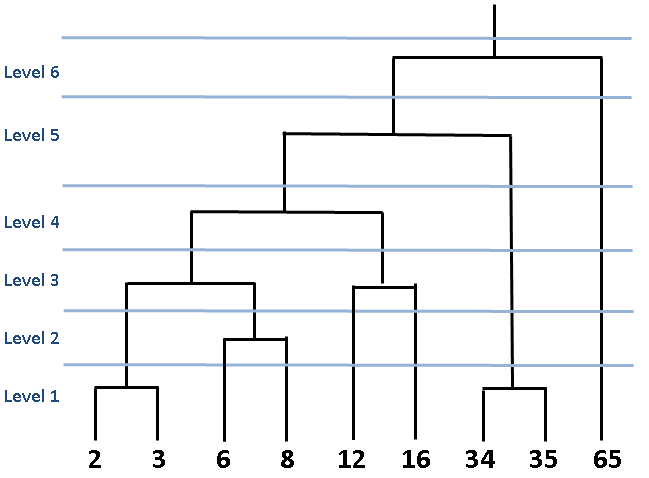


The linkage criteria determines the metric used for the merge strategy:

- Ward minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.

- Maximum or complete linkage minimizes the maximum distance between observations of pairs of clusters.

- Average linkage minimizes the average of the distances between all observations of pairs of clusters.

- Single linkage minimizes the distance between the closest observations of pairs of clusters.


#### Modeling our Country data

In [294]:
# 7.0 Perform Agglomerative clustering
#     Setting distance_threshold=0 ensures we compute the full tree.
# Ref: https://towardsdatascience.com/hierarchical-clustering-explained-e58d2f936323
#      https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html

# 7.1
cols = ["TotalPurchases", 	"StockVariety", 	"CustomerCounts"]
model = AgglomerativeClustering(
                                distance_threshold=0,
                                n_clusters=None  
                                )
# 7.2
model = model.fit(X[cols])

In [ ]:
# 7.3 How clusters have been formed:
z = shc.linkage(model.children_,'ward')
z

In [ ]:
# 7.4 Draw dendogram:

_= plt.figure(figsize = (20,10))
dn = shc.dendrogram(z)

##### Looking at clusters

In [ ]:
# 7.5 Add two more columns to 
#     our dataset: X

X['Country'] = rcs['Country']
X['c_label'] = model.labels_
X.head(2)

In [298]:
# 8.0 Define a function to show relevant
#     rows, given cluster label(s) or nodes:

def showData(label1,label2, label3 = None):
  if (label3 is None):
      return X.loc[(X['c_label'] == label1) | (X['c_label'] == label2), :]
  else:
      return X.loc[(X['c_label'] == label1) | (X['c_label'] == label2)| (X['c_label'] == label3), :]    

In [ ]:
# 8.1 Now display data, given cluster labels:
#     Note that each value or datapoint is 
#     a z-score value:

print(showData(10,24))
print("xxxxxxx")
print(showData(33,34))
print("xxxxxxx")
print(showData(0,6))

Interpretation of Linkage data with created dendogram OR given linkage data, how a dendogram can be created:

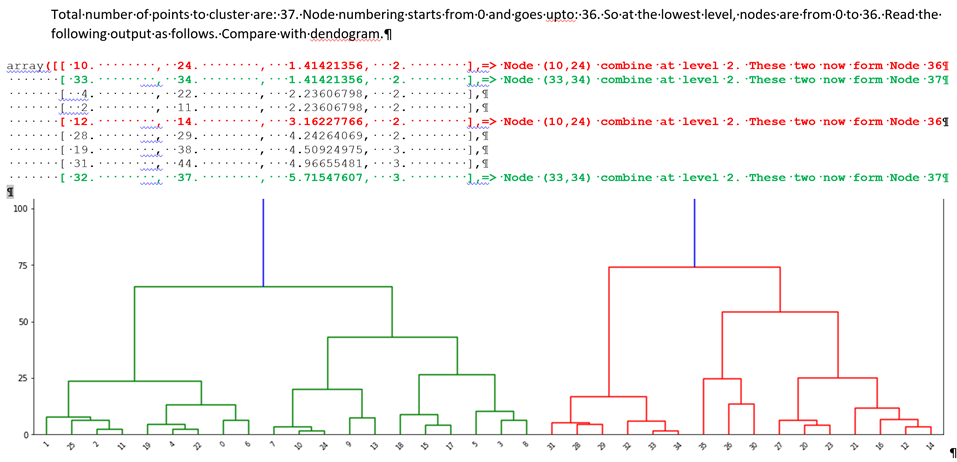

###Visualize *rfm* Distributions  

#####Univariate

In [ ]:
# 9.1
fig = px.histogram(rfm, x = "frequency")
fig.show()

In [ ]:
# 9.2
fig = px.histogram(rfm, x = "recency")
fig.show()

In [ ]:
# 9.3
fig = px.histogram(rfm, x = "revenue")
fig.show()

In [ ]:
# 9.3.1
fig = px.histogram(rfm, x = "avg_unitprice")
fig.show()

#####Jointplots

In [ ]:
# 9.4
fig = px.density_heatmap(
                         rfm,
                         x="frequency",
                         y="recency"
                         )
# 9.4.1. Set x-limits
fig.update_xaxes(range=[0, 50])


In [ ]:
# 9.5
fig = px.density_heatmap(
                         rfm,
                         x="frequency",
                         y="recency",
                         marginal_x="histogram"                        
                         )
# 9.5.1 Set x-limits
fig.update_xaxes(range=[0, 25])

In [ ]:
# 9.6
fig = px.density_contour(rfm, x="revenue", y="recency")
fig.update_xaxes(range=[0, 10000])

In [ ]:
# 9.7
fig = px.density_contour(rfm, x="revenue", y="recency")
_=fig.update_traces(contours_coloring="fill", contours_showlabels = True)
fig.update_xaxes(range=[0, 10000])

### Removing outliers
There is no rigid mathematical definition of what constitutes an outlier; determining whether or not an observation is an outlier is ultimately a subjective exercise. There are various methods of outlier detection. Some are graphical such as normal probability plots. Others are model-based. Box plots are a hybrid.

Model-based methods which are commonly used for identification assume that the data are from a normal distribution, and identify observations which are deemed "unlikely" based on mean and standard deviation: 

Before we cluster data:
>a. Remove outliers<br>
>> i) Use IQR method  
>> ii)Use z-score  
>>iii)Use IsolationForest algorithm  

>b. Perform boxcox transformation to make relevant features symmteric

IQR

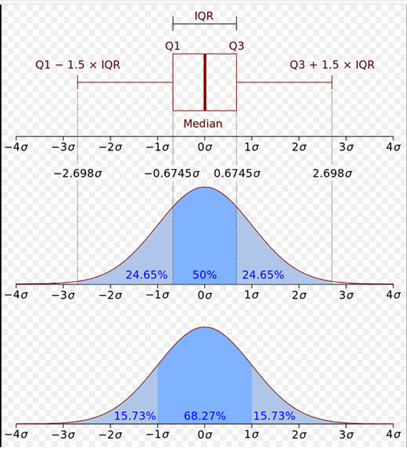



Quantile vs Quartile vs Percentile<br>
Refer [here](https://stats.stackexchange.com/a/156787)

> 0 quartile = 0 quantile = 0 percentile

> 1 quartile = 0.25 quantile = 25 percentile

> 2 quartile = .5 quantile = 50 percentile (median)

> 3 quartile = .75 quantile = 75 percentile

> 4 quartile = 1 quantile = 100 percentile


In [ ]:
# 10.0 One way to look at outliers in rfm data:

_=rfm.boxplot()

In [309]:
# 10.0.1
cols = ["revenue", "frequency", "recency"]
cols1 = ["revenue", "frequency", "recency", "avg_unitprice"]
cols2 = ["revenue", "frequency", "recency", "avg_unitprice", "weekday"]


### Box-cox transformations

In statistics, a power transform is a family of functions that are applied to create a monotonic transformation of data using power functions. This is a useful data transformation technique used to stabilize variance, make the data more normal distribution-like, improve the validity of measures of association such as the Pearson correlation between variables and for other data stabilization procedures. 

##### An example of Variance Stabilization

In [ ]:
# 11.0 Last amended: 15th April, 2021
# Myfolder:
# https://stats.stackexchange.com/a/336397

x1 = np.random.lognormal(2,1.3, 500)  # 500 elements
x2 = np.random.lognormal(2,1.3,500)   # 500 elements
X = 2*x1+x2
Y = 2*x2+x1   

# 11.0.1 Plot 
_=plt.title("Variance increases as X-increases: Heteroskedasticity")
_=plt.scatter(y,z)
_=plt.xlim(0,500)
_=plt.xlabel("X -->")
_=plt.ylabel("Y -->")

In [ ]:
# 11.1 Take a log of both 'x' and 'y'
_=plt.scatter(np.log10(X),np.log10(Y))
_=plt.xlabel("X -->")
_=plt.ylabel("Y -->")

In [310]:
# 11.2  Define a function to perform
#       boxcox transformation on a dataframe: x

from sklearn.preprocessing import power_transform

def boxcox(X):
  """
  X: Dataframe on each feature of
     which transformation is to be carried out
  """
  dataColumns = X.columns
  X = power_transform(X.values, method = 'yeo-johnson')
  X = pd.DataFrame(X, columns=dataColumns)
  return X

In [ ]:
# 11.3
rfm_boxcox = boxcox(rfm[cols1])

_=sns.displot(rfm_boxcox, x = "frequency")
_=sns.displot(rfm_boxcox, x = "revenue")
_=sns.displot(rfm_boxcox, x = "recency")
_=sns.displot(rfm_boxcox, x = "avg_unitprice")

In [ ]:
# 11.4 Calculate few stats:

cols = ["revenue", "frequency", "recency"]
print("\n\n----0.99 quantile-----\n")
rfm[cols].quantile(0.99)
print("\n\n----0.75 quantile-----\n")
rfm[cols].quantile(0.75)
print("\n\n----0.25 quantile-----\n")
rfm[cols].quantile(0.25)
print("\n\n----iqr-----\n")
iqr = rfm[cols].quantile(0.75) - rfm[cols].quantile(0.25)
print()
iqr  # rev: 1316, recency: 132,frequency: 4.0 

In [ ]:
# 11.5 Use scipy stats:

# 11.5.1 Calcluate IQR for each feature:
iqr_rev = stats.iqr(rfm.revenue, interpolation = 'midpoint')
iqr_recency = stats.iqr(rfm.recency, interpolation = 'midpoint')
iqr_freq = stats.iqr(rfm.frequency, interpolation = 'midpoint')

# 11.5.2
print()
print("iqr_rev:", iqr_rev)
print("iqr_recency: ", iqr_recency)
print("iqr_freq: ", iqr_freq)

#### Using IQR to calculate outliers

#### Remove outlier function

In [315]:
# 12.0 Function removes outliers
def rem_outliers(feature, data):
  """
  Given a 'feature' and a DataFrame,
  this function removes rows with
  outliers in 'feature' and returns
  remaining DataFrame.
  """
  # 12.1
  q1 = data[feature].quantile(0.25)
  q3 = data[feature].quantile(0.75)
  iqr = q3-q1
  # 12.2
  upper_lt = q3 + iqr * 1.5
  lower_lt = q1 - iqr * 1.5
  # 12.3
  return data.loc[(data[feature] >lower_lt) & (data[feature] < upper_lt), : ] 

#### Remove outlier from 'frequency' feature

In [ ]:
# 12.3.1
print(rem_outliers.__doc__)

In [ ]:
# 13.0 Remove outliers from 'frequency' feature:
rfm_freq = rem_outliers('frequency', rfm) 
rfm_freq.shape    # (3913,4)
rfm_freq.head()


In [ ]:
# 13.1 Do outlier still remain in other
#     features also?

fig = px.histogram(rfm_freq, x = "frequency", width=600, height=400)
fig1 = px.histogram(rfm_freq, x = "recency", width=600, height=400)
fig2 = px.histogram(rfm_freq, x = "revenue", width=600, height=400)

fig.show()
fig1.show()
fig2.show()

In [ ]:
# 13.2 Look at boxplots also:
fig = plt.figure(figsize=(8,6))
_=rfm_freq[cols1].boxplot()

#### Remove outlier from 'recency' feature

In [ ]:
# 13.3
rfm_recency = rem_outliers('recency', rfm) 

# 13.3.1
rfm_recency.shape    # (4244, 4)
rfm_recency.head()


In [ ]:
# 13.4 So after removal from 'recency'
#     let us look at outliers again

fig = px.histogram(rfm_recency, x = "frequency", width=600, height=400)
fig1 = px.histogram(rfm_recency, x = "recency", width=600, height=400)
fig2 = px.histogram(rfm_recency, x = "revenue", width=600, height=400)

fig.show()
fig1.show()
fig2.show()

#### Remove outliers from 'revenue' feature

In [ ]:
# 13.5
rfm_revenue = rem_outliers('revenue', rfm) 

# 13.5.1
rfm_revenue.shape    # (4244, 4)
rfm_revenue.head()


In [ ]:
# 13.5.2
fig = px.histogram(rfm_revenue, x = "frequency", width=600, height=400)
fig1 = px.histogram(rfm_revenue, x = "recency", width=600, height=400)
fig2 = px.histogram(rfm_revenue, x = "revenue", width=600, height=400)

fig.show()
fig1.show()
fig2.show()

#### Remove both 'revenue' and 'frequency' outliers

In [ ]:
# 13.6 Remove both 'revenue' and 'frequency' outliers
rfm_freq2 = rem_outliers('frequency', rfm_revenue) 
rfm_freq2.shape    # (4244, 4)
rfm_freq2.head()


In [ ]:
# 13.7

fig = px.histogram(rfm_freq2, x = "frequency", width=600, height=400)
fig1 = px.histogram(rfm_freq2, x = "recency", width=600, height=400)
fig2 = px.histogram(rfm_freq2, x = "revenue", width=600, height=400)

fig.show()
fig1.show()
fig2.show()

#### Another way to remove outliers
Look at 5th percentile and 95th percentile

In [ ]:
# 14.0 Another way

#14.1  Removing (statistical) outliers for revenue
lower_rev = rfm.revenue.quantile(0.05)
upper_rev = rfm.revenue.quantile(0.95)
rfm_aw = rfm[(rfm.revenue >= lower_rev) & (rfm.revenue <= upper_rev)]

#14.2 Removing (statistical) outliers for recency
lower_rec = rfm.recency.quantile(0.05)
upper_rec = rfm.recency.quantile(0.95)
rfm_aw = rfm_aw[(rfm_aw.recency >= lower_rec) & (rfm_aw.recency <= upper_rec)]

#14.3 Removing (statistical) outliers for frequency
lower_freq = rfm_aw.frequency.quantile(0.05)
upper_freq = rfm_aw.frequency.quantile(0.95)
rfm_aw = rfm_aw[(rfm_aw.frequency >= lower_freq) & (rfm_aw.frequency <= upper_freq)]

#14.3.1 Removing (statistical) outliers for avg_unitprice
lower_up = rfm_aw.avg_unitprice.quantile(0.05)
upper_up = rfm_aw.avg_unitprice.quantile(0.95)
rfm_aw = rfm_aw[(rfm_aw.avg_unitprice >= lower_up) & (rfm_aw.avg_unitprice <= upper_up)]


# 14.4
rfm_aw.shape  # (3442, 5)
rfm_aw.head()

In [ ]:
# 14.5
fig = px.histogram(rfm_aw, x = "frequency", width=600, height=400)
fig1 = px.histogram(rfm_aw, x = "recency", width=600, height=400)
fig2 = px.histogram(rfm_aw, x = "revenue", width=600, height=400)
fig3 = px.histogram(rfm_aw, x = "avg_unitprice", width=600, height=400)

fig.show()
fig1.show()
fig2.show()
fig3.show()

#### Box-cox transformation
Perform boxcox transformation on 'inlier' data

In [ ]:
# 14.5.1 Now that outliers have been
#       removed from data, we can perform boxcox
#       transformation here.
#       Boxcox transformation will also scale data.
#       You can use:

# rfm_aw = boxcox(rfm_aw)


##### Scale Data now
Scale data from which outliers are removed

In [ ]:
# 16.0 Rescaling the attributes

rfm_df = rfm_aw[cols1]

# 16.1 Instantiate
scaler = StandardScaler()

# 16.2 fit_transform
X = scaler.fit_transform(rfm_df)
X.shape  # (3096, 4)

In [ ]:
# 16.3 Transform scaled numpy data to DataFrame
rfm_df_scaled = pd.DataFrame(X)
rfm_df_scaled.columns = ['revenue', 'frequency', 'recency', 'avg_unitprice']
rfm_df_scaled.head()

### Isolation forest for outlier removal
See [here](https://quantdare.com/isolation-forest-algorithm/)

How do we separate each point? The simple procedure is as follows for each point of the data set:

1.    Select the point to isolate.
2.     For each feature, set the range to isolate between the minimum and the maximum.
3.     Choose a feature randomly.
4.     Pick a value that’s in the range, again randomly:
>i)         If the chosen value keeps the point above, switch the minimum of the range of the feature to the value.  
>ii)        If the chosen value keeps the point below, switch the maximum of the range of the feature to the value.
5. Repeat steps 3 & 4 until the point is isolated. That is, until the point is the only one which is inside the range for all features.
6. Count how many times you’ve had to repeat steps 3 & 4. We call this quantity the isolation number.

The algorithm claims that a point is an outlier if it doesn’t have to repeat the steps 3 & 4 several times.

In [ ]:
# 17.0
from sklearn.ensemble import IsolationForest

# 17.0.1 Instantiate a quick model
clf = IsolationForest(random_state=0)

# 17.0.2 Train the model:
clf.fit(X)

# # 17.0.3 PRedict outliers and inliers 
# predict()
#   Returns 'is_inlier' ndarray of shape (n_samples,)
#   For each observation, tells whether or not (+1 or -1)
#   it should be considered as an inlier according to the fitted model.

out = clf.predict(X)
out[:10]

In [ ]:
# 17.0.4 So extract 'normal' data
X_normal = X[out == 1]
X_normal.shape   # (2220, 4)

In [ ]:
# 17.0.5 Transform scaled numpy data to DataFrame
X_normal = pd.DataFrame(X_normal)
X_normal.columns = ['revenue', 'frequency', 'recency', 'avg_unitprice']
X_normal.head()

In [ ]:
# 17.1 Visualize the 'normal' data
fig1 = px.histogram(X_normal, x = "revenue", width = 400, height= 400)
fig2 = px.histogram(X_normal, x = "frequency", width = 400, height= 400)
fig3 = px.histogram(X_normal, x = "recency", width = 400, height= 400)
fig4 = px.histogram(X_normal, x = "avg_unitprice", width = 400, height= 400)

# 17.1.1
fig1.show()
fig2.show()
fig3.show()
fig4.show()

### KMeans clustering
We use data without boxcox transformation

#### Scree plot
How many clusters?

In [ ]:
# 18.0 Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    _=kmeans.fit(rfm_df_scaled)
  
    ssd.append(kmeans.inertia_)
    
# 18.1 plot the SSDs for each n_clusters
_=plt.plot(ssd)

#### Silhoutte Score

In [ ]:
# 18.2 Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    _=kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

#### Final model

In [339]:
# 18.3 Final model with k=3
#      Why 3? From domain knowledge, I think 3 would be OK.

kmeans = KMeans(n_clusters=3, max_iter=50)
_=kmeans.fit(rfm_df_scaled)

In [ ]:
# 18.4 Assign cluster labels
rfm_df_scaled['Cluster_Id'] = kmeans.labels_
rfm_df_scaled.head()

### Are clusters interpretable:
Look at clusters, cluster_ID wise


In [ ]:
# 18.5.1 Draw boxplots
#sns.boxplot(x='Cluster_Id', y='revenue', data=rfm_df_scaled);
fig = px.box(rfm_df_scaled, x='Cluster_Id', y="revenue")
fig.show()

In [ ]:
# 18.5.2 Draw boxplots
#sns.boxplot(x='Cluster_Id', y='recency', data=rfm_aw);
fig = px.box(rfm_df_scaled, x='Cluster_Id', y="recency")
fig.show()

In [ ]:
# 18.5.3
fig = px.box(rfm_df_scaled, x='Cluster_Id', y="frequency")
fig.show()
# sns.boxplot(x='Cluster_Id', y='frequency', data=rfm_aw);

In [ ]:
# 18.5.4
fig = px.box(rfm_df_scaled, x='Cluster_Id', y="avg_unitprice")
fig.show()
# sns.boxplot(x='Cluster_Id', y='frequency', data=rfm_aw);

In [ ]:
# 18.5.5 Are medians significantly different
#        If there is an overlap in error-bars, then no
#        Note: Some medians are negative

ax=sns.barplot(data = rfm_df_scaled,
            x='Cluster_Id', 
            y="avg_unitprice",
            estimator = np.median)


### Gaussian Mixture Model

#### Perform boxcox again
This time with data without outliers

In [ ]:
# 19.0 Boxcox transformation
from sklearn.preprocessing import power_transform

# 19.1
rfm_boxcox = power_transform(
                              rfm_df_scaled[cols1],
                              method = 'yeo-johnson'
                              )

# 19.2 PErform boxcox again
rfm_boxcox = pd.DataFrame(rfm_boxcox, columns=cols1)
_=sns.displot(rfm_boxcox, x = "frequency")
_=sns.displot(rfm_boxcox, x = "revenue")
_=sns.displot(rfm_boxcox, x = "recency")
_=sns.displot(rfm_boxcox, x = "avg_unitprice")

In [ ]:
# 19.4
_=sns.displot(rfm_df_scaled, x = "frequency")
_=sns.displot(rfm_boxcox, x = "frequency")

# 19.5
print()
_=sns.displot(rfm_df_scaled, x = "recency")
_=sns.displot(rfm_boxcox, x = "recency")

# 19.6
print()
_=sns.displot(rfm_df_scaled, x = "revenue")
_=sns.displot(rfm_boxcox, x = "revenue")

# 19.7
print()
_=sns.displot(rfm_df_scaled, x = "avg_unitprice")
_=sns.displot(rfm_boxcox, x = "avg_unitprice")

In [ ]:
# 20.0 Create a dataset
#      that mixes boxcox and scaled transformations

rfm_mix = rfm_df_scaled.copy()
rfm_mix['frequency']= rfm_boxcox['frequency']
rfm_mix['recency'] = rfm_boxcox['recency']
#rfm_mix['revenue'] = rfm_boxcox['revenue']
rfm_mix['avg_unitprice'] = rfm_boxcox['avg_unitprice']
rfm_mix.head()

In [ ]:
# 20.1 Import GaussianMixture class
from sklearn.mixture import GaussianMixture

# 20.2 Instantiate model
gm = GaussianMixture(
                     n_components = 3,
                     n_init = 30,
                     max_iter = 200)

# 20.3 Train the algorithm
cols = ['frequency', 'recency', 'revenue']

# 20.4
gm.fit(rfm_mix[cols])

# 20.5 Where are the clsuter centers
print("\n-----cluster means----\n")
gm.means_

# 20.6 Did algorithm converge?
print("\n-----Did it converge?----\n")
gm.converged_

# 20.7 How many iterations did it perform?
print("\n-----How many iteratons?----\n")
gm.n_iter_

In [ ]:
# 21.0
silhouette_avg = silhouette_score(rfm_mix[cols], gm.predict(rfm_mix[cols]))
silhouette_avg

In [351]:
# 21.1 Predict clusters labels
cid = gm.predict(rfm_mix[cols])

In [ ]:
# 21.2
rfm_mix['cid'] = cid
rfm_mix.head()

#### In each cluster, one feature is a distinguishing feature

In [ ]:
# 22.0
sns.boxplot(x='cid', y='revenue', data=rfm_mix);

In [ ]:
# 22.1
sns.boxplot(x='cid', y='recency', data=rfm_mix);

In [ ]:
# 22.2
sns.boxplot(x='cid', y='frequency', data=rfm_mix);

> Cluster 1: High revenue + low recency + high frequency  

> Cluster 2: Low revenue + high recency + low frequency  

> Cluster 3: Low revenue + low recency + low frequency  


In [ ]:
############# I am done ###########

In [ ]:
bic = []
aic = []
cols = ['frequency', 'recency', 'revenue']
for i in range(10):
    print()
    print("No of clusters: ", i)
    print()
    gm = GaussianMixture(
                     n_components = i+1,
                     n_init = 10,
                     max_iter = 200,
                     init_params="kmeans")
    gm.fit(rfm_df_boxcox)
    bic.append(gm.bic(rfm_df_boxcox))
    aic.append(gm.aic(rfm_df_boxcox))

In [ ]:
bic = []
aic = []
cols = ['frequency', 'recency', 'revenue']
for i in range(50):
    print()
    print("No of clusters: ", i)
    print()
    gm = GaussianMixture(
                     n_components = i+1,
                     n_init = 10,
                     max_iter = 100)
    gm.fit(rfm_df_scaled[cols])
    bic.append(gm.bic(rfm_df_scaled[cols]))
    aic.append(gm.aic(rfm_df_scaled[cols]))

In [ ]:
str(5) + str("aa")

'5aa'

In [ ]:
# https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html
bic = []
aic = []
lowest_bic = np.infty
n_components_range = range(1, 15)
cv_types = ['spherical', 'tied', 'diag', 'full']

for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gm = GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gm.fit(rfm_mix[cols])
        bic.append(cv_type + ":" +str(gm.bic(rfm_mix[cols])))
        aic.append(cv_type + ":" +str(gm.aic(rfm_mix[cols])))
        if gm.bic(rfm_mix[cols]) < lowest_bic:
            lowest_bic = gm.bic(rfm_mix[cols])
            best_gm = gm

In [ ]:
aic
print()
bic

In [ ]:
rfm_mix.to_csv("rfm_mix.csv",index=False)

In [ ]:
####### I am done ##############